In [29]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
import scipy
from scipy import stats
#import matplotlib.colors as mcolorsxx

# %load_ext autoreload
# %autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
from databuilder.data_loader import universaldataloader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
from model.metric import iqr_basic
import databuilder.data_loader as data_loader
from utils.filemethods import open_data_file
from trainer.trainer import Trainer
from model.build_model import TorchModel
from base.base_model import BaseModel
from utils import utils
from shash.shash_torch import Shash
import analysis.calc_climatology as calc_climatology
from analysis import analysis_metrics
from utils.utils import filter_months
import analysis
from analysis import CRPS
from analysis import ENSO_indices_calculator
from analysis.analysis_metrics import load_pickle, save_pickle

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")


python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
numpy version = 1.26.4
xarray version = 2024.5.0
pytorch version = 2.0.0.post104


In [3]:
# Open exp015 shash predictions and CRPS scores: 
config = utils.get_config("exp021")
seed = config["seed_list"][0]

# Open Model Outputs
model_output = str(config["perlmutter_output_dir"]) + str(config["expname"]) + '/' + str(config["expname"]) + '_network_SHASH_parameters.pkl'
output = analysis_metrics.load_pickle(model_output)
print(f"output shape: {output.shape}")

CRPS_network = analysis_metrics.load_pickle(str(config["perlmutter_output_dir"]) + str(config["expname"]) + "/" + str(config["expname"]) + "CRPS_network_values.pkl")
CRPS_climatology = analysis_metrics.load_pickle(str(config["perlmutter_output_dir"]) + str(config["expname"]) + "/" + str(config["expname"]) + "CRPS_climatology_values.pkl")


output shape: (14753, 4)


In [4]:
# Open Target Data
s_dict_savename3 = str(config["perlmutter_inputs_dir"]) + str(config["expname"]) + "_d_test.pkl"
target = universaldataloader(s_dict_savename3, config, target_only = True, repackage = False)
print(f"UDL target shape: {target.shape}")

Opened pickle file: /pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp021_d_test.pkl
UDL target shape: (14753,)


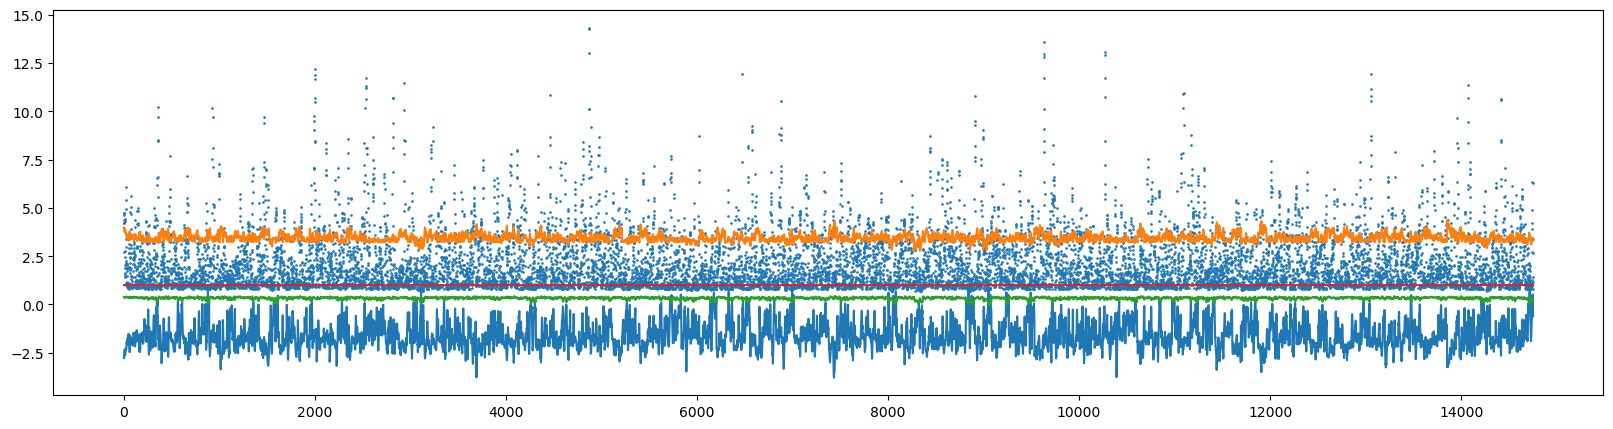

In [5]:
plt.figure(figsize = (20, 5))
plt.scatter(range(len(CRPS_network)), CRPS_network, s = 0.8)
plt.plot(output[:, 0])
plt.plot(output[:, 1])
plt.plot(output[:, 2])
plt.plot(output[:, 3])

/global/common/software/m4620/conda/envs/env-torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/m4620/conda/envs/env-torch/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


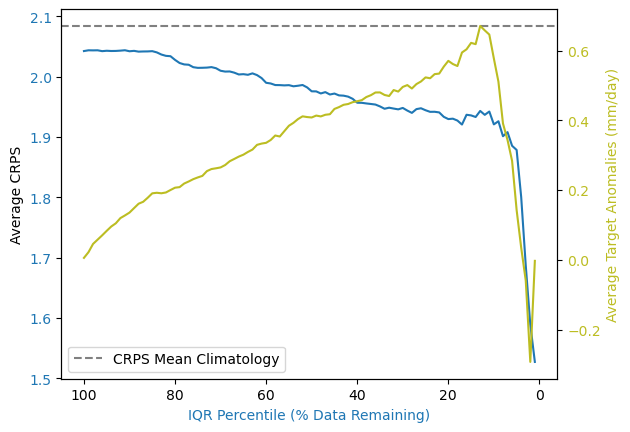

In [6]:
sample_index = analysis_metrics.discard_plot(output, target, CRPS_network, CRPS_climatology, config, target_type = 'anomalous')

/global/common/software/m4620/conda/envs/env-torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/m4620/conda/envs/env-torch/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


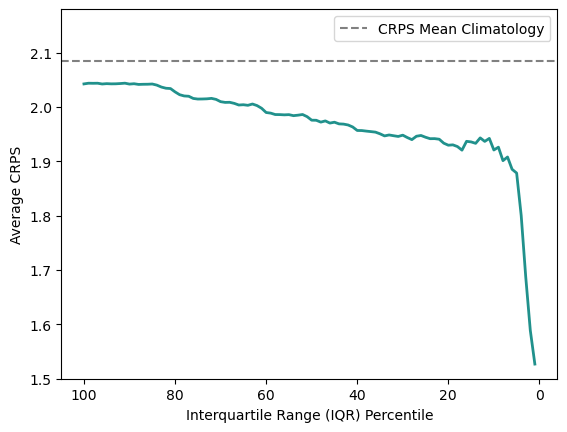

In [7]:
iqr = iqr_basic(output)

percentiles = np.linspace(100, 0, 101)

avg_crps = []
avg_target = []
sample_index = np.zeros((len(target), len(percentiles)))
for ip, p in enumerate(percentiles):
    avg_crps.append(np.mean(CRPS_network[iqr < np.percentile(iqr, p)]))
    avg_target.append(np.mean(target[iqr < np.percentile(iqr, p)]))
    # capture the index (out of total) for all the samples in each bin
    indices = np.where(iqr < np.percentile(iqr, p))[0]
    sample_index[:len(indices), ip] = indices

color = '#21918c'
fig, ax1 = plt.subplots()
plt.gca().invert_xaxis()
ax1.set_ylabel('Average CRPS')
ax1.set_xlabel('Interquartile Range (IQR) Percentile')
ax1.plot(percentiles, avg_crps, color=color, linewidth = 2)
ax1.tick_params(axis='y')
ax1.axhline(y=CRPS_climatology.mean(), color='grey', linestyle='--', label='CRPS Mean Climatology')
ax1.set_ylim([1.5, 2.18])
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# legend
ax1.legend(loc = 'upper right')

plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/exp021/AMS_discardplot.png', transparent = True, format = 'png', dpi = 350)

(14753, 101)
148
Opened pickle file: /pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp021_d_train.pkl
UDL climatology shape (14753,)
Climatologial Mean = <xarray.DataArray 'PRECT' ()> Size: 8B
array(-0.00051024)


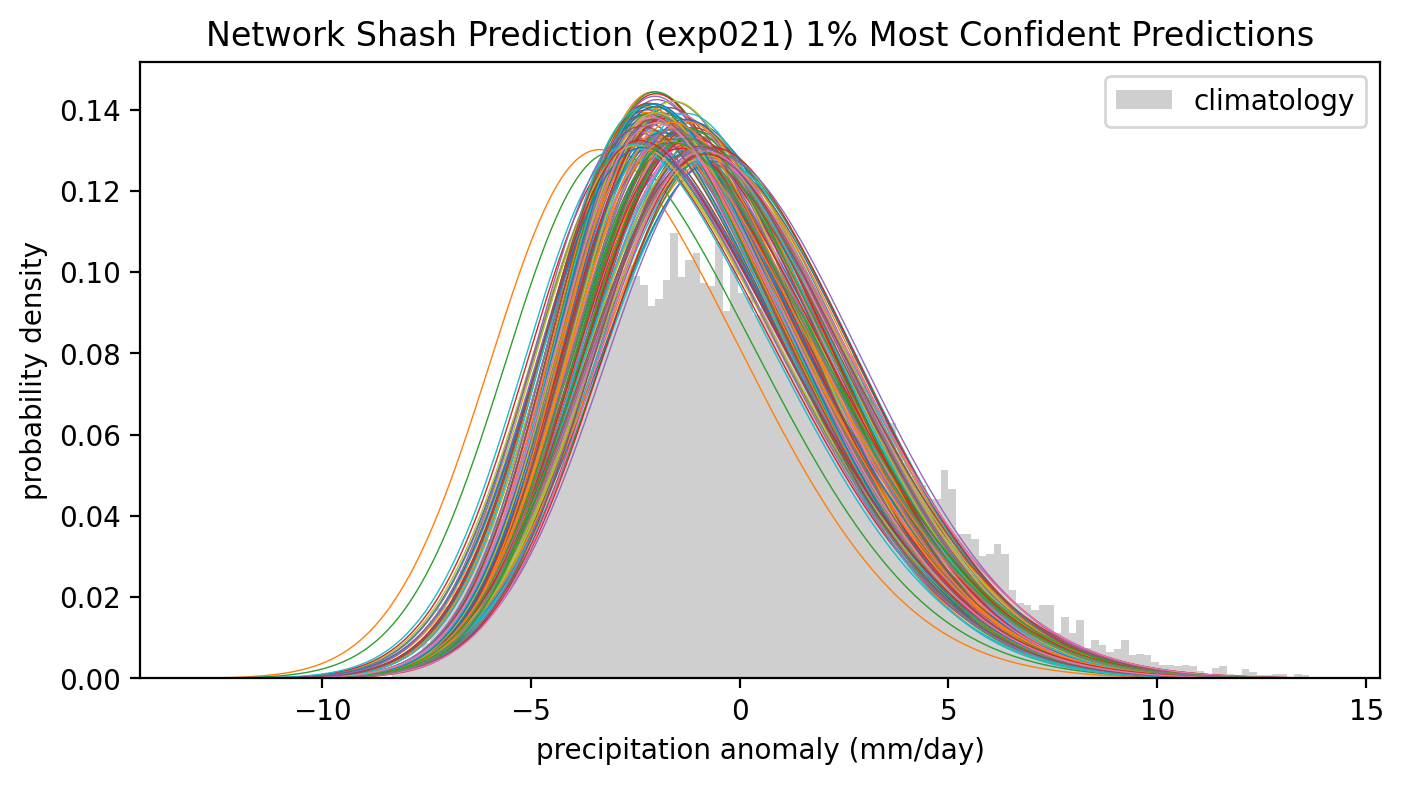

In [8]:
print(sample_index.shape)

conf1 = sample_index[:, 99]
# Filter out zeros to keep only the nonzero values: 443 predictions
nonzero_conf1 = conf1[conf1 != 0].astype(int)
print(len(nonzero_conf1))

# Open Climatology Data: TRAINING DATA
climatology_filename = str(config["perlmutter_inputs_dir"]) + str(config["expname"]) + "_d_train.pkl"
climatology = universaldataloader(climatology_filename, config, target_only = True, repackage = False)
print(f"UDL climatology shape {climatology.shape}")

# Compare SHASH predictions to climatology histogram
x_coarse = np.arange(-13, 14, 0.18)
x_fine = np.arange(-13, 14, 0.01)

# Plot SHASH of most confident 3% of Samples which most likely align with El Nino
print(f"Climatologial Mean = {np.mean(climatology)}")

dist = Shash(output[nonzero_conf1, :])
p1 = dist.prob(x_fine).numpy()

plt.figure(figsize=(8, 4), dpi=200)
plt.hist(
    climatology, x_coarse, density=True, color="silver", alpha=0.75, label="climatology"
)

plt.plot(x_fine, p1, linewidth = 0.5 ) #label = samples
plt.xlabel("precipitation anomaly (mm/day)")
plt.ylabel("probability density")
plt.title("Network Shash Prediction (" + str(config["expname"] + ") 1% Most Confident Predictions"))
# plt.axvline(valset[:len(output)], color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.savefig(str(config["perlmutter_figure_dir"]) + str(config["expname"]) + '/' + str(config["expname"]) + '_predictions_w_climatology.png', format='png', bbox_inches ='tight', dpi = 300)
# plt.xlim([-10, 12])

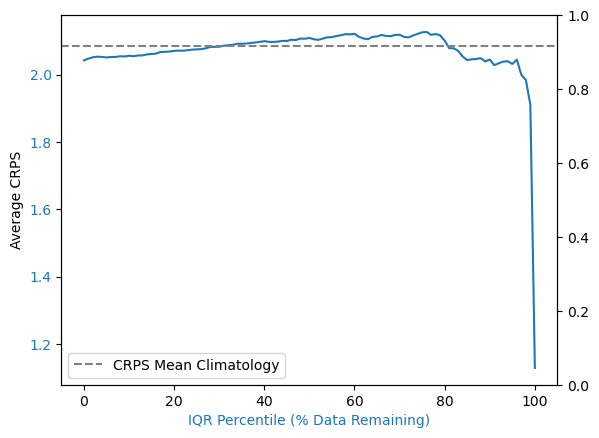

In [9]:
# Calculate widest samples / Least Confident Samples

iqr = iqr_basic(output)

percentiles = np.linspace(0, 100, 101)

avg_crps = []
avg_target = []
sample_index_WIDE = np.zeros((len(target), len(percentiles)))
for ip, p in enumerate(percentiles):
    avg_crps.append(np.mean(CRPS_network[iqr >= np.percentile(iqr, p)]))
    avg_target.append(np.mean(target[iqr >= np.percentile(iqr, p)]))
    # capture the index (out of total) for all the samples in each bin
    indices = np.where(iqr > np.percentile(iqr, p))[0]
    sample_index_WIDE[:len(indices), ip] = indices

color = 'tab:blue'
fig, ax1 = plt.subplots()
# plt.gca().invert_xaxis()
ax1.set_ylabel('Average CRPS')
ax1.set_xlabel('IQR Percentile (% Data Remaining)', color=color)
ax1.plot(percentiles, avg_crps, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=CRPS_climatology.mean(), color='grey', linestyle='--', label='CRPS Mean Climatology')
# ax1.set_ylim([1.05, 1.205])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# legend
ax1.legend(loc = 'lower left')

(2700, 148)
[0.14436536 0.14432973 0.14388781 0.1432655  0.14243689]


(0.0, 0.15)

<Figure size 1500x1200 with 0 Axes>

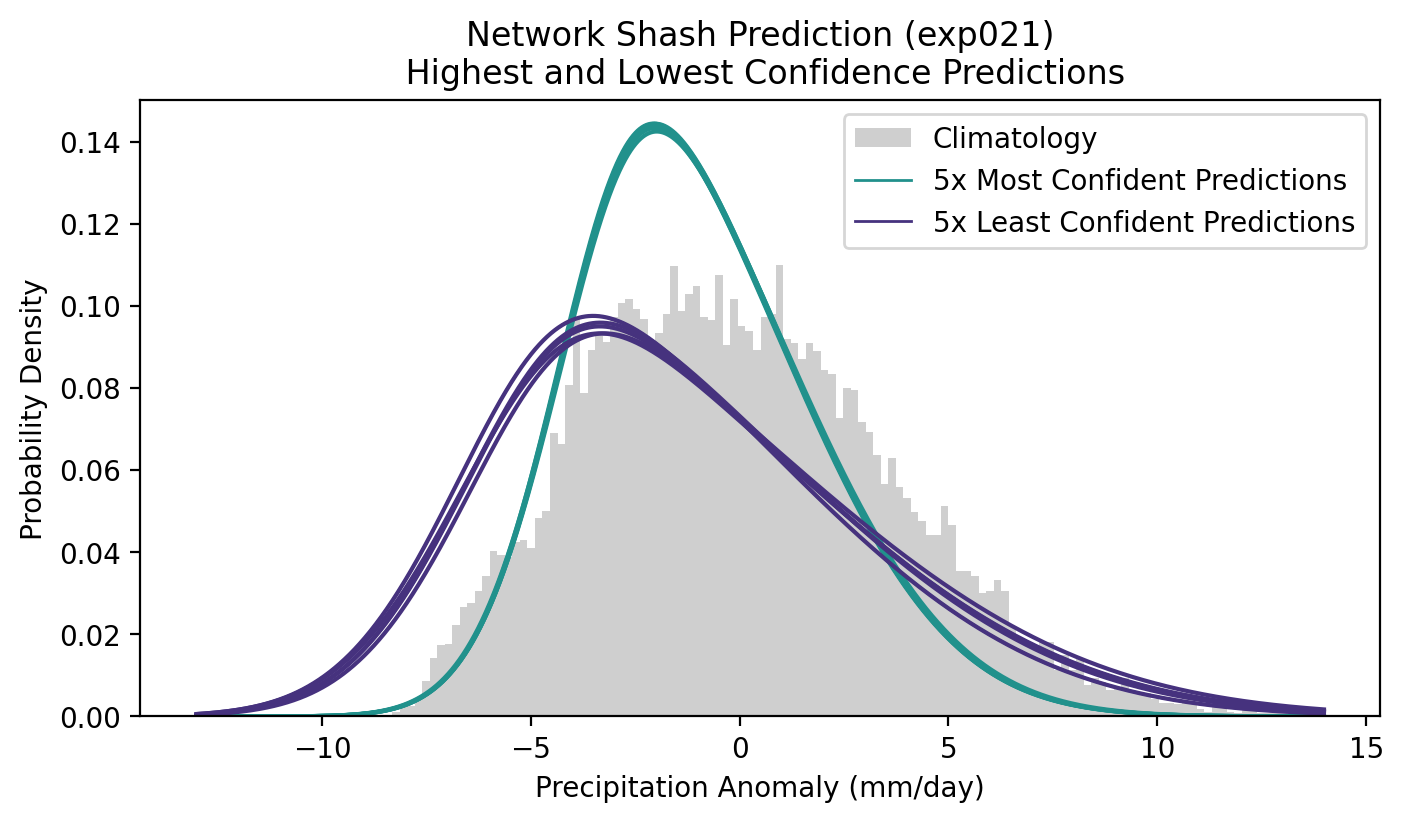

In [16]:
plt.figure(figsize= (15, 12))

# MOST CONFIDENT SAMPLES: ---------------------
# Extract the specific values from the output
conf1_SHASHparams = output[nonzero_conf1, :]

# mu_conf1 = conf1_SHASHparams[:, 2]

# # Get the indices of the 5 lowest values
# lowest_mu_indices = mu_conf1.argsort()[:10]

# # find the indices of the lowest values in context of the full output dataset: (which sample numbers are these)
# i_specialshash = nonzero_conf1[lowest_mu_indices]

# # Map these back to the original indices in `nonzero_conf3`
# most_unique_samples = conf1_SHASHparams[lowest_mu_indices, :]

# top5_shashs = most_unique_samples[5:9]
# print(top5_shashs)
print(p1.shape)

maxP_columns = np.max(p1, axis=0)

# Find the indices of the columns with the 5 highest values
top_5_columns = np.argsort(maxP_columns)[-5:][::-1]  
print(maxP_columns[top_5_columns])

top5_shashs = conf1_SHASHparams[top_5_columns, :]

ihigh_conf_shash = nonzero_conf1[top_5_columns]

# LEAST CONFIDENT SAMPLES ----------------------
conf99 = sample_index_WIDE[:, 99]
nonzero_conf99 = conf99[conf99 != 0].astype(int)

conf99_SHASHparams = output[nonzero_conf99, :]
mu_conf99 = conf99_SHASHparams[:, 0]

# Get the indices of the 5 lowest values
mu_indices99 = mu_conf99.argsort()[:5]

# find the indices of the lowest values in context of the full output dataset: (which sample numbers are these)
ilow_conf_shash = nonzero_conf99[mu_indices99]

# Map these back to the original indices
least_conf_shashes = conf99_SHASHparams[mu_indices99, :]

# top5_shashs = most_unique_samples[5:9]
# print(top5_shashs)


# DISTS ==================
dist = Shash(top5_shashs)
p_top5 = dist.prob(x_fine).numpy()

dist = Shash(least_conf_shashes)
p_bot5 = dist.prob(x_fine).numpy()

# dist = Shash(other_shashs)
# p_o = dist.prob(x_fine).numpy()

# -------------------------

plt.figure(figsize=(8, 4), dpi=200)
plt.hist(
    climatology, x_coarse, density=True, color="silver", alpha=0.75, label="Climatology"
)

plt.plot(x_fine, p_top5, linewidth = 1.5, color = '#21918c')
plt.plot(x_fine, p_top5[:, 0], linewidth = 1, color = '#21918c', label = '5x Most Confident Predictions') #label = samples
plt.plot(x_fine, p_bot5, linewidth = 1.5, color = '#46327e')
plt.plot(x_fine, p_bot5[:, 0], linewidth = 1, color = '#46327e', label = '5x Least Confident Predictions')
# plt.plot(x_fine, p[:, 5:9], color = 'red')
plt.xlabel("Precipitation Anomaly (mm/day)")
plt.ylabel("Probability Density")
plt.title("Network Shash Prediction (" + str(config["expname"] + ")\n Highest and Lowest Confidence Predictions"))
# plt.axvline(valset[:len(output)], color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.savefig(str(config["perlmutter_figure_dir"]) + str(config["expname"]) + '/' + str(config["expname"]) + '_predictions_w_climatologyAMS.png', format='png', transparent = True, bbox_inches ='tight', dpi = 350)
# plt.xlim([-10, 12])
plt.ylim([0, 0.150])

### Check Most and Least Confident Samples

In [35]:
print(ilow_conf_shash)

print(ihigh_conf_shash)

[ 7435  7437 11908  7436  7438]
[8274 8275 8276 8334 8277]


Data passed directly as <class 'xarray.core.dataarray.DataArray'> rather than filename.
Save Pickle outputs: 
File saved as:  /pscratch/sd/p/plutzner/E3SM/saved/output/exp021/exp021ENSO_indices_CRPS.pkl
El Nino average CRPS across all samples: 1.8762
La Nina average CRPS across all samples: 2.0871
Neutral average CRPS across all samples: 2.1138


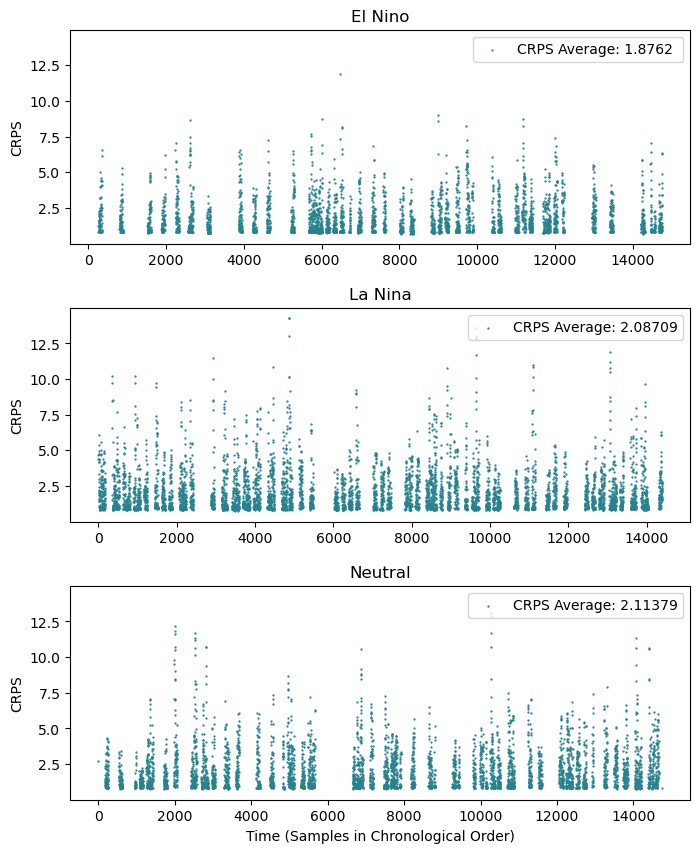

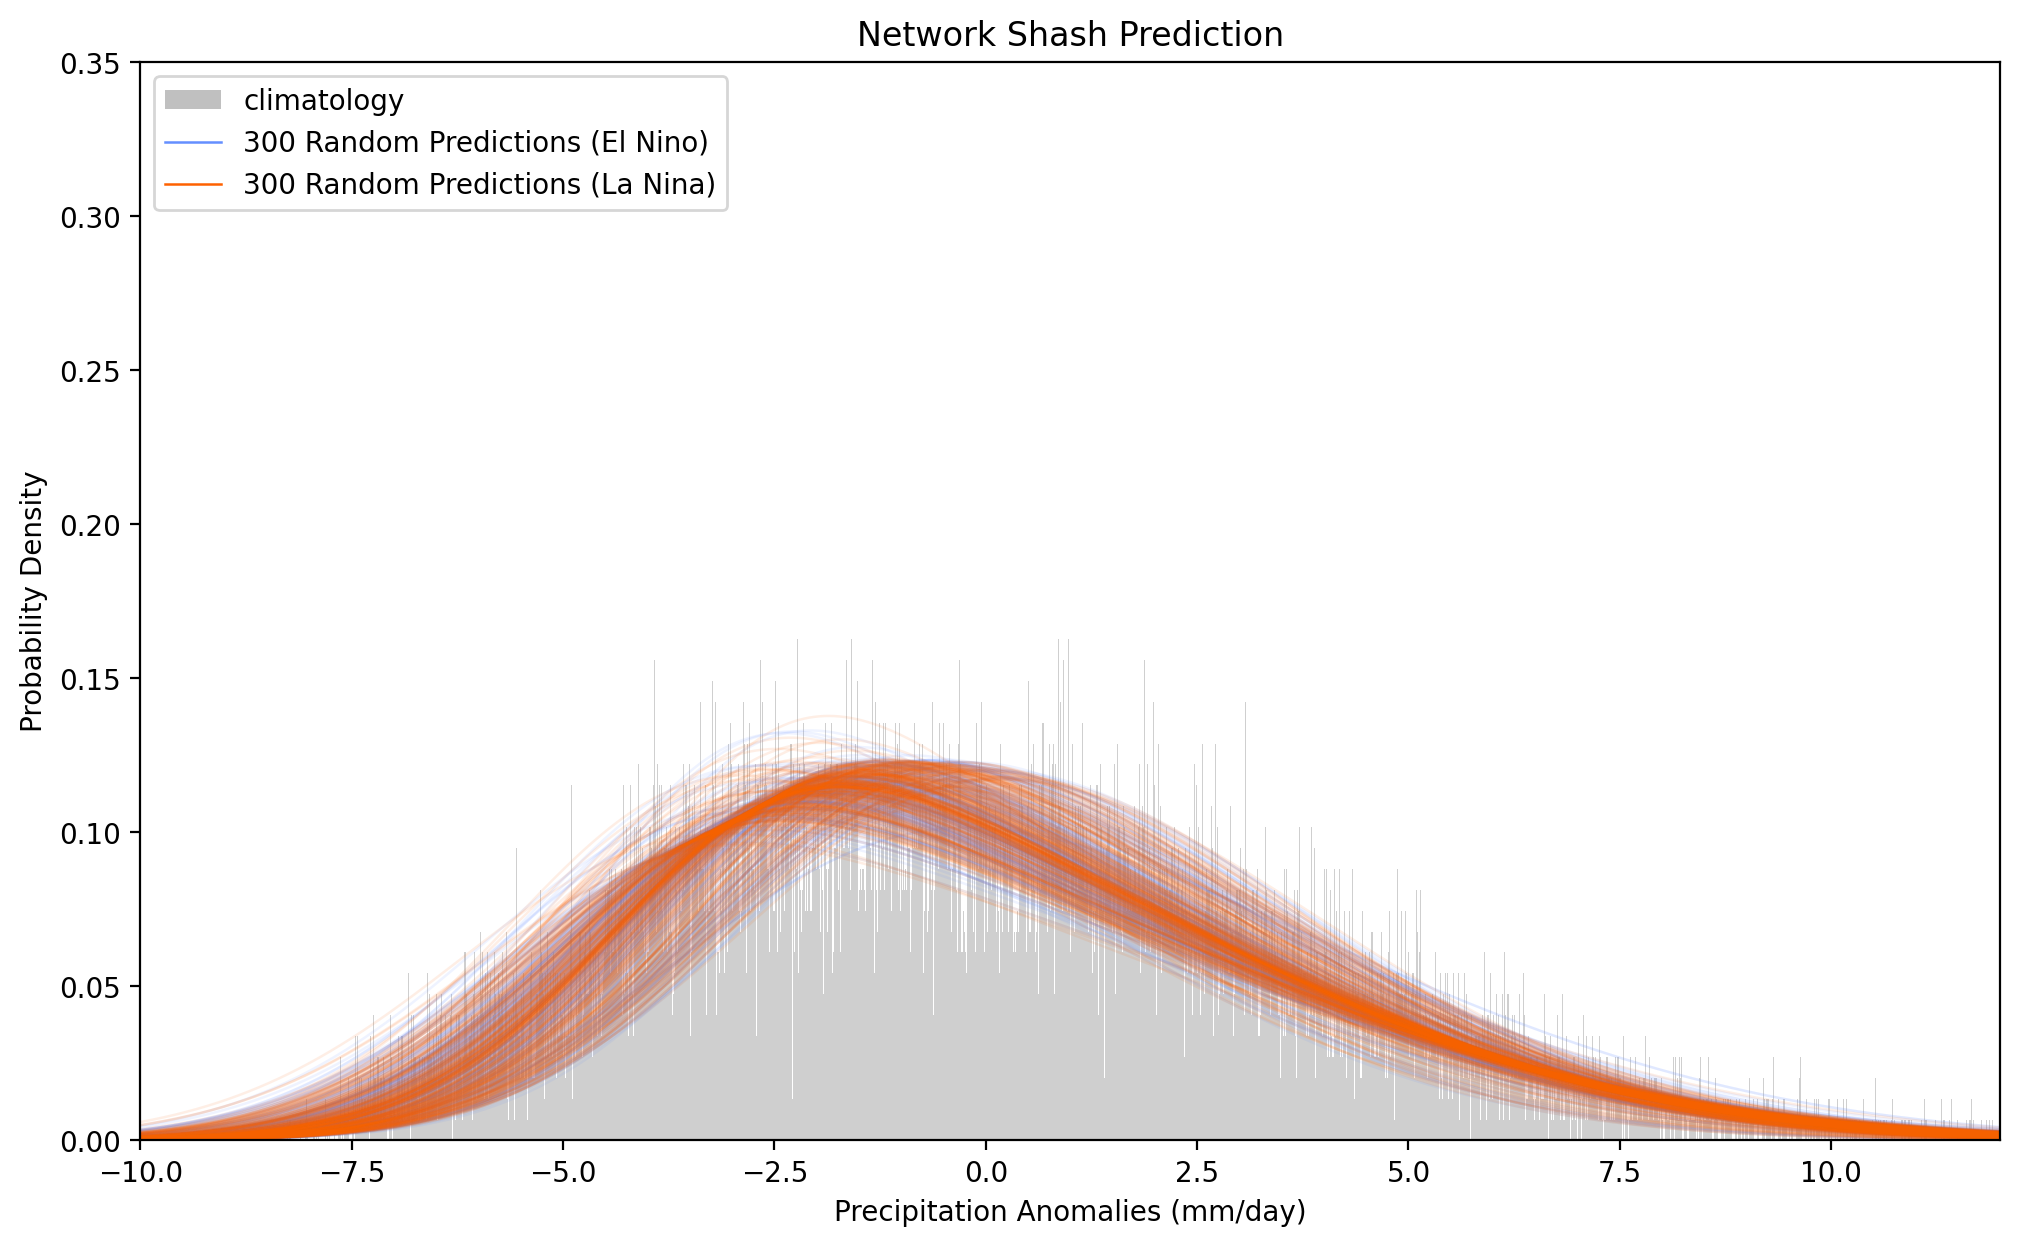

In [28]:
import analysis.analysis_metrics
imp.reload(ENSO_indices_calculator)

lagtime = config["databuilder"]["lagtime"] 
smoothing_length = config["databuilder"]["averaging_length"]  
selected_months = config["databuilder"]["target_months"]
front_cutoff = config["databuilder"]["front_cutoff"] 
back_cutoff = config["databuilder"]["back_cutoff"] 

# Calculate ENSO Indices from Monthly ENSO Data (Po-Lun): 
monthlyENSO = xr.open_dataset('/pscratch/sd/p/plutzner/E3SM/bigdata/presaved/ENSO_ne30pg2_HighRes/nino.member0201.nc')
Nino34 = monthlyENSO.nino34
# select a slice of only certain years
Nino34 = Nino34.sel(time=slice ( str(config["databuilder"]["input_years"][0]) + '-01-01', str(config["databuilder"]["input_years"][1]) + '-12-31'))
Nino34 = Nino34.values

enso_indices_daily = ENSO_indices_calculator.identify_nino_phases(Nino34, config, threshold=0.4, window=6, lagtime = lagtime, smoothing_length = smoothing_length)

# Separate CRPS scores by ENSO phases 
elnino, lanina, neutral, CRPS_elnino, CRPS_lanina, CRPS_neutral = analysis.ENSO_indices_calculator.ENSO_CRPS(enso_indices_daily, CRPS_network, climatology, x_fine, output, config)

In [61]:
# Open ENSO indices and CRPS Scores: 
ENSO_dict = load_pickle('/pscratch/sd/p/plutzner/E3SM/saved/output/exp021/exp021ENSO_indices_CRPS.pkl')

ihigh_conf_shashLAG = ihigh_conf_shash - 14
ilow_conf_shashLAG = ilow_conf_shash - 14

elnino = np.array(ENSO_dict["elnino"]).T
lanina = np.array(ENSO_dict["lanina"]).T
neutral = np.array(ENSO_dict["neutral"]).T
CRPS = np.array(ENSO_dict["CRPS"]).T

CRPS_hc = CRPS[ihigh_conf_shash]
CRPS_lc = CRPS[ilow_conf_shash]


def whichphase(indices, elnino, lanina, neutral): 
    sorted_samples = np.zeros([len(indices), 3]) # Columns: ELNINO, LANINA, NEUTRAL
    for i, index in enumerate(indices):
        if index in elnino: 
           sorted_samples[i, 0] = index
        elif index in lanina:
            sorted_samples[i, 1] = index
        elif index in neutral:
            sorted_samples[i, 2] = index
        else: 
            print("Index not in any phase?")

    print(f"El Nino  La Nina  Neutral \n {sorted_samples}")
    return sorted_samples

sortedsamples_HC = whichphase(ihigh_conf_shashLAG, elnino, lanina, neutral)
sortedsamples_LC = whichphase(ilow_conf_shashLAG, elnino, lanina, neutral)

El Nino  La Nina  Neutral 
 [[   0.    0. 8260.]
 [   0.    0. 8261.]
 [   0.    0. 8262.]
 [8320.    0.    0.]
 [   0.    0. 8263.]]
El Nino  La Nina  Neutral 
 [[    0.  7421.     0.]
 [    0.  7423.     0.]
 [    0. 11894.     0.]
 [    0.  7422.     0.]
 [    0.  7424.     0.]]


In [58]:
CRPS_lc
print(f"CRPS: Low Conf Samples \n {CRPS_lc}")
print(f"CRP Mean Low Conf Samples \n {np.mean(CRPS_lc)}")

CRPS: Low Conf Samples 
 [[1.66071595]
 [1.20137003]
 [1.64045409]
 [1.39114429]
 [1.43567673]]
CRP Mean Low Conf Samples 
 1.4658722168322371


In [59]:
CRPS_hc
print(f"CRPS: High Conf Samples \n {CRPS_hc}")
print(f"CRPS Mean High Conf Samples \n {np.mean(CRPS_hc)}")

CRPS: High Conf Samples 
 [[1.2176003 ]
 [1.07978675]
 [0.90511245]
 [1.82307527]
 [0.68305941]]
CRPS Mean High Conf Samples 
 1.141726837684374
